# Uncertainty

## Section 1: Data vs Model Uncertainty
Uncertainty can arise from noisy data, model architecture, incomplete data, etc. and generally can be classified as either model or data uncertainty. From them modeler's point of view, we are most concerned with model uncertainty since we are able to improve our models through training of a DNN. We can use the Bayesian framework to formalize model uncertainty as the probabliity distribution over model parameters $\theta$ for a given dataset, and data uncertainty as the probility distribution over our outputs $y^*$ given a parameterized model $f_\theta$

[1] A Survey of Uncertainty in Deep Neural Networks. Figure 11.

$p(y^*|x^*, D) = \int \underbrace{p(y^*|x^*, \theta)}_{\text{Data}} \underbrace{p(\theta|D)}_{\text{Model}} \, d\theta$

### 1.1 Data Uncertainty
Data uncertainty can be traced to errors in data measurement, and is caused by a loss of information when translating real world observations into measurable ones. In a classification task with the MNIST dataset, data uncertainty could be caused by lower resolution versions of the images. In a regression task predicting various qualities of wine, any inaccuracies caused by the measuring equipment, weather, or human error cannot be learned by the neural network. Data uncertainty is considered irreducible due to the imperfect manner in which we collect data and conduct experiments. This introduces an unavoidable element of randomness that causes variability in experiment outcomes. This means we can only estimate data uncertainty, since reducing it is not a possibility.

[1]

![Figure 1](fuzzymnist.png)
![Figure 2](winequality.png)

[2] Generative models and Bayesian inversion using Laplace approximation Figure 2.

### 1.2 Model Uncertainty
Epistemic uncertainty is caused by the model, which is why its referred to as model uncertainty. Model uncertainty is typically encapsulated by errors in architecture design, training procedures, or insufficient training data . As the modeler, we have full control over both the architecture and training procudure, thus model uncertainty is theoretically reducible. Therefore it is our goal as modelers to create DNNs that can handle uncertain inputs, reduce or remove model uncertainty, and provide data uncertainty estimates for our predictions.

[1]

## Section 2: Approaches to Modeling Uncertainty

### 2.1 Single Deterministic Methods

#### 2.1.1 MC Dropout

MC Dropout employs dropout layers after each weight layer in the network to randomly turn on and off weight layers during training and test time. Normal dropout would only drop layer during training time, but MC Dropout is able to generate a distribution of predictions for a given input due to the non-deterministic nature of dropout layers applied during testing. This introduces an element of randomness that allows us to produce an approximate posterior predictive by taking the average prediction over $T$ samples and calculating the variance. This approach attempts to capture model uncertainty through its use of dropout layers, but assumes homogenous data noise.

[3] Qualitative Analysis of Monte Carlo Dropout Section 2.3.1

#### 2.1.2 Two Moons Dataset


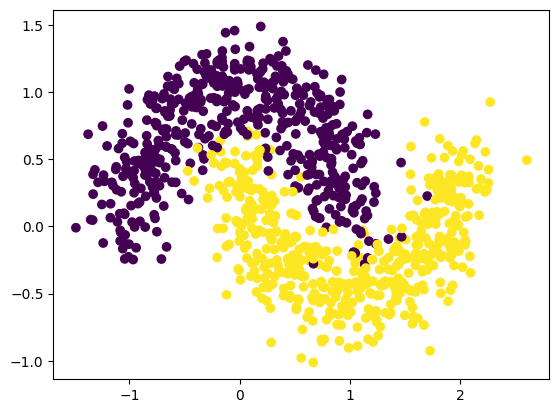

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# Create the dataset
X, y = make_moons(n_samples=1000, noise=0.2, shuffle=True)
train_X, train_y = X[:800], y[:800]
test_X, test_y = X[800:], y[800:]

# Convert to PyTorch Dataset
train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
test_dataset = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).long())

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Plot the Two Moon dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#### 2.1.3 Two Moons Model

In [2]:
import torch.nn.functional as F
import torch.nn as nn


class TwoMoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(2, 64)
        self.dropout1 = nn.Dropout(p=0.2)
        # hidden layers
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.2)
        # output layer
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        # Dropout layer
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#### 2.1.4 Training in Push

In [3]:
from push.bayes.mc_dropout import MultiMCDropout

epochs = 100
dropout_model = TwoMoonsModel()
loss_fn = nn.CrossEntropyLoss()
mc_dropout = MultiMCDropout.train_mc_dropout(train_dataloader, loss_fn, epochs, TwoMoonsModel, patch=True, size_ensemble=3)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:29<00:00,  3.41it/s, loss: =tensor(0.2343, device='cuda:0', grad_fn=<DivBackward0>)]


#### 2.1.5 Test dataset

In [4]:
# Inputs to use for plotting the decision boundary
XX, YY = np.meshgrid(np.linspace(-3.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
X_tensor = torch.tensor(XX, dtype=torch.float32)
Y_tensor = torch.tensor(YY, dtype=torch.float32)
inputs = torch.stack((X_tensor, Y_tensor), dim=2).view(-1, 2)

#### 2.1.6 Inference

In [5]:
# Get all the samples
outputs = mc_dropout.posterior_pred(inputs, num_samples=20, f_reg=True, mode="raw")

#### 2.1.7 Visualizing

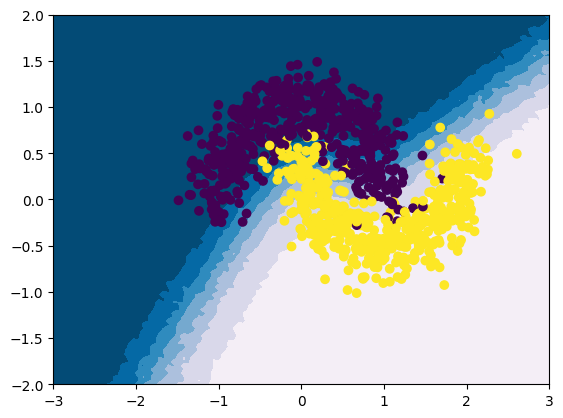

In [6]:
mean_outputs = outputs.mean(dim=1).softmax(dim=1)[:, 1]
ZZ_mean = mean_outputs.reshape((100,100))

plt.contourf(XX, YY, ZZ_mean, cmap=cm.PuBu_r)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#### 2.2.1 Prior Networks
A prior can be thought of as a guess about the problem before any training occurs. A prior network seeks to enforce some *prior* belief about our model's parameters before encountering any data. Prior weights may be initialized with a distribution like Dirilicht, Gaussian, uniform, etc. It allows us to quantify uncertainty by randomly initializing a series of priors to generate non-deterministic predictions. It can also act as a form of regularization and prevent overfitting through its non-deterministic qualities.

#### 2.2.2 Dataset

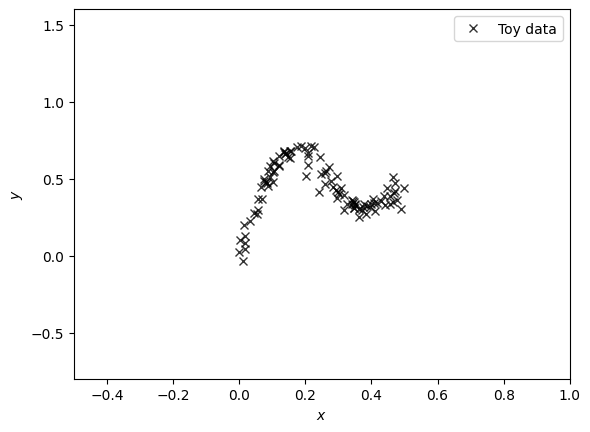

In [7]:
# Inspired by randomized_priors.py from [1] Probabilistic Machine Learning Advanced Topics. Chapter 17.
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Set a seed for reproducibility
torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])


# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

#### 2.2.3 Model
In our implementation of a prior network, we opted to create two sets of parameters for every trained model, $\theta_{prior}$ and $\theta_{trainable}$. $\theta_{prior}$ is randomly initialized and left alone during the training process. This is done because the randomly initialized parameters of the prior network represent our prior beliefs, and we will use these parameters in our forward pass calculations. $\theta_{trainable}$ will be optimized with an Adam optimizer for mean square error loss. On a forward pass, the prior networks weights $\theta_{prior}$ will be multiplied by a hyperparameter $\beta$ that controls how biased our predictions are toward the prior. Then the trainable networks parameters, $\theta_{trainable}$ are added. This acts as a form of regularization, causing each model to be biased toward a specific prior. When utilzied within an ensemble this be utilized to quantify data uncertainty. In areas with high data uncertainty, the prior $\theta_{prior}$ should have an extreme influence on predictions due to the trainable parameters not having enough data in that region. In areas with low data uncertainty, the trainable weights $\theta_{trainable}$ should have an extreme influence on predictions. 

$\theta_{priornet}$ = $\beta * \theta_{prior} + \theta_{trainable}$

In [8]:
# Inspired by randomized_priors.py from [1] Probabilistic Machine Learning Advanced Topics. Chapter 17.
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, beta):
        super(Model, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2


#### 2.2.4 Training

In [9]:
# Inspired by randomized_priors.py from [1] Probabilistic Machine Learning Advanced Topics. Chapter 17.
# Function to create train state with key initialization
def create_train_optim(model, lr):
    model.train()  # Set the model in training mode
    optimizer = optim.Adam(model.trainable.parameters(), lr=lr)
    return optimizer

# Training function
def train(model, optimizer, epochs, X, Y):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.mean((output - Y)**2)
        loss.backward()
        optimizer.step()
    return model

# Prediction function
def get_predictions(model, X):
    model.eval()
    with torch.no_grad():
        Y_prior = model.prior(X)
        Y_trainable = model.trainable(X)
        Y_model = model(X)
    return Y_prior, Y_trainable, Y_model

    
# Create model and optimizer
beta = 3
lr = 0.03
epochs = 2000
# Set a random seed for reproducibility
seed = 2

# Create model and optimizer
torch.manual_seed(seed)
model = Model(beta=beta)
optimizer = create_train_optim(model, lr=lr)

# Train the model
model = train(model, optimizer, epochs=epochs, X=X, Y=Y)

# Get predictions
# predictions = get_predictions(model, beta=3, X=X)
Y_prior, Y_trainable, Y_model = get_predictions(model, x_grid)

#### 2.2.5 Visualizing

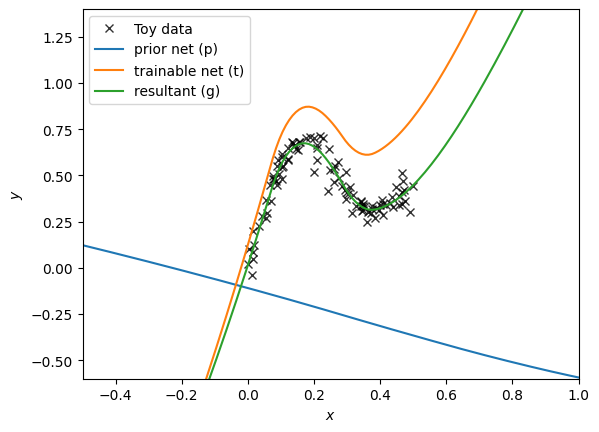

In [10]:
# Inspired by randomized_priors.py from [1] Probabilistic Machine Learning Advanced Topics. Chapter 17.
# Plot the results
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
plt.plot(x_grid, 3 * Y_prior, label="prior net (p)")
plt.plot(x_grid, Y_trainable, label="trainable net (t)")
plt.plot(x_grid, Y_model, label="resultant (g)")
# plt.title('Predictions of the prior network: random function')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.6, 1.4)
plt.legend()

# plt.savefig("randomized_priors_single_model.pdf")
# plt.savefig("randomized_priors_single_model.png")

plt.show()

### 2.3 Bayesian Inference
Bayesian inference methods seek to directly approximate the posterior distribution.

#### 2.3.1 Multi-Swag

#### 2.3.2 Dataset
We will use the same toy dataset employed in section 2.2.2.

In [11]:
# Set a seed for reproducibility
torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

#### 2.3.3 Model

For our model lets use the same base model, GenericNet, as used in section 2.2.3. We will use the Multi-Swag algorithm to make a distribution of weight values with a mean and diagonal covariance matrix. From this we can generate sample predictions, which we will average to determine our prediction result.

In [12]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
    def forward(self, x):
        return self.net(x)

#### 2.3.4 Training

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



import torch
from torch.utils.data import DataLoader
import push.bayes.swag
from experiments.nns.bdl import GenericNet


lr = 0.03
# seed = 2
# torch.manual_seed(seed)
num_models=9
pretrain_epochs = 2000
swag_epochs = 1000



# def train_mswag(dataloader: DataLoader, loss_fn: Callable, pretrain_epochs: int,
#                 swag_epochs: int, nn: Callable, *args, lr: float = 0.01, num_devices=1,
#                 cache_size: int = 4, view_size: int = 4, num_models: int = 1,
#                 cov_mat_rank: int=20, prior = False, random_seed = False, bootstrap = False,
#                 mswag_entry=_mswag_particle, mswag_state={}, f_save=False,
#                 mswag_sample_entry=_mswag_sample_entry, mswag_sample=_mswag_sample):

mswag = push.bayes.swag.train_mswag(
        train_loader,
        torch.nn.MSELoss(),
        pretrain_epochs,
        swag_epochs,
        GenericNet, 1,
        lr = lr,
        num_devices=2,
        num_models=num_models
    )


  1%|          | 13/2000 [00:00<00:58, 33.77it/s, loss=tensor(0.0325)]

100%|██████████| 1000/1000 [00:49<00:00, 20.34it/s, loss=tensor(0.0025)]


#### 2.3.5 Inference

In [14]:
mswag_outputs = mswag.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])


In [18]:
mswag_outputs["mean"].squeeze()

tensor([-2.1104e+01, -2.1066e+01, -2.1027e+01, -2.0988e+01, -2.0949e+01,
        -2.0910e+01, -2.0871e+01, -2.0832e+01, -2.0793e+01, -2.0754e+01,
        -2.0715e+01, -2.0676e+01, -2.0637e+01, -2.0598e+01, -2.0559e+01,
        -2.0520e+01, -2.0482e+01, -2.0443e+01, -2.0404e+01, -2.0365e+01,
        -2.0326e+01, -2.0287e+01, -2.0248e+01, -2.0209e+01, -2.0170e+01,
        -2.0131e+01, -2.0092e+01, -2.0053e+01, -2.0014e+01, -1.9975e+01,
        -1.9936e+01, -1.9897e+01, -1.9858e+01, -1.9819e+01, -1.9780e+01,
        -1.9741e+01, -1.9702e+01, -1.9663e+01, -1.9624e+01, -1.9585e+01,
        -1.9546e+01, -1.9507e+01, -1.9468e+01, -1.9429e+01, -1.9390e+01,
        -1.9351e+01, -1.9312e+01, -1.9273e+01, -1.9234e+01, -1.9195e+01,
        -1.9156e+01, -1.9117e+01, -1.9078e+01, -1.9039e+01, -1.9000e+01,
        -1.8961e+01, -1.8922e+01, -1.8883e+01, -1.8844e+01, -1.8805e+01,
        -1.8766e+01, -1.8727e+01, -1.8688e+01, -1.8649e+01, -1.8610e+01,
        -1.8571e+01, -1.8532e+01, -1.8493e+01, -1.8

In [22]:
len(x_grid)
len(mswag_outputs["mean"].squeeze())

1000

#### 2.3.6 Visualizing

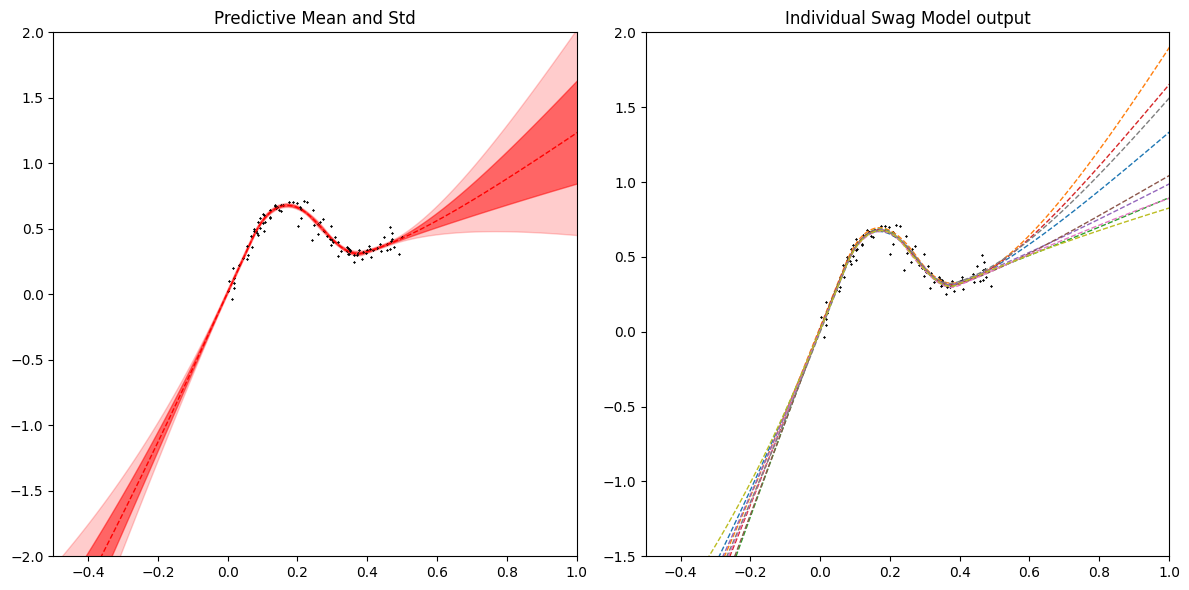

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have some data X, Y, x_grid, outputs, num_ensembles defined



fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])

# Plot predictive mean and std (left graph)
axs[0].plot(X, Y, "kx", label="Toy data", markersize=1)
axs[0].set_xlim(-0.5, 1)
axs[0].set_ylim(-2, 2)
axs[0].plot(x_grid, mswag_outputs["mean"], "r--", linewidth=1)
axs[0].fill_between(x_grid.reshape(1, -1)[0], (mswag_outputs["mean"] - mswag_outputs["std"]).squeeze(), (mswag_outputs["mean"] + mswag_outputs["std"]).squeeze(), alpha=0.5, color="red")
axs[0].fill_between(
    x_grid.reshape(1, -1)[0], (mswag_outputs["mean"] + 2 * mswag_outputs["std"]).squeeze(), (mswag_outputs["mean"] - 2 * mswag_outputs["std"]).squeeze(), alpha=0.2, color="red"
)
axs[0].set_title("Predictive Mean and Std")

# Plot means of each net in ensemble (right graph)
axs[1].plot(X, Y, "kx", label="Toy data", markersize=1)
axs[1].set_xlim(-0.5, 1)
axs[1].set_ylim(-1.5, 2)
axs[1].set_title("Individual Swag Model output")

for j in range(num_models):
    axs[1].plot(x_grid, torch.tensor([sublist[j] for sublist in mswag_outputs["pred"]]), linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


#### 2.x.2 Stein Variational Gradient Descent

### 2.4 Ensemble Approaches

#### 2.4.1 Simple Ensemble

#### 2.4.2 Random Initialization

#### 2.4.3 Bootstrapping

### 2.5 Test Time Data Augmentation

## Section 3: Uncertainty Classification

### 3.1 In Domain Uncertainty
MNIST - Show simple plot of probabilities and logits for a single example

### 3.2 Domain Shift Uncertainty

### 3.3 Out of Domain Uncertainty
MNIST - train on numbers 1-5, test on 6-9, show the uncertainty
sine wave - obvious

References 

[1] Gawlikowski, J., Njieutcheu Tassi, C. R., Ali, M., Lee, J., Humt, M., Feng, J., Kruspe, A., Triebel, R., Jung, P., Roscher, R., Shahzad, M., Yang, W., Bamler, R., & Zhu, X. X. (2022). A Survey of Uncertainty in Deep Neural Networks. arXiv preprint arXiv:2107.03342.

[2] Marschall, M., Wübbeler, G., Schmähling, F., & Elster, C. (2023). Generative models and Bayesian inversion using Laplace approximation. Computational Statistics, Advance online publication. https://doi.org/10.1007/s00180-023-01345-5

[3] Seoh, Ronald. "Qualitative Analysis of Monte Carlo Dropout." University of Massachusetts Amherst, Amherst, MA, 13 December 2019, arXiv:2007.01720 [stat.ML], https://arxiv.org/pdf/2007.01720.pdf

[4] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.

[5] Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, Ruslan R. Salakhutdinov.. Improving neural networks by preventing co-adaptation of feature detectors. https://arxiv.org/abs/1207.0580.

[6] Yarin Gal and Zoubin Ghahramani. Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. Proceedings of The 33rd International Conference on Machine Learning, 2016.